# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation, to help with Assignment 1B, Question 2.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from keras.models import Model

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import glob

### Data loading and pre-processing functions

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.

One thing you may want to do is create additional augmentation functions, and the ``flip_lr_augmentation`` function below could be used as a template to create additional augmentation types. 

In [2]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
        
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)

def flip_lr_augmentation(image, output, flip_lr_prob):
    """ function to return perform left-right flip augmentation

    The function will flip the image along the left-right axis with
    a defined probability.
    """

    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob 
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    seg = output[1]
    
    # wrapper fn for when we do the flip
    def flip():
        flipped_image = tf.image.flip_left_right(image)
        flipped_seg = tf.image.flip_left_right(seg)
        return flipped_image, flipped_seg

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, seg

    # apply augmentation    
    image, seg = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, (output[0], seg)

def select_tasks(image, output, classification=True, segmentation=True):
    """select the tasks to include the data

    By default for each input there are two outputs. This function allows
    you to select which outputs to use, so the problem can be reduced to a
    single task problem for initial experimenting.    
    """
    # both tasks
    if classification and segmentation:
        return image, output
    # just classification
    elif classification:
        return image, output[0]
    # just segmentation
    elif segmentation:
        return image, output[1]
    # neither task, doesn't really make sense, so return the image
    # for a self-supervised task
    else:
        return image, image

class TrainForTime(keras.callbacks.Callback):
    """callback to terminate training after a time limit is reached

    Can be used to control how long training runs for, and will terminate
    training once a specified time limit is reached.
    """
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

### Data Loader

We will now put the above functions together into a data loader that we can use to feed directly to the network. You can you this directly as it is. However, you may modify it to add some additional functionality such as further data augmentations.

In [3]:
def load_oxford_pets(split,
                     batch_size=233,
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    augment : bool
        whether to augment the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    # Check fior a valid dataset split, this must be train or test
    if (split != 'train') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True
    # check that if using the test split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
    # check that if using the test split, augment if false. If not, print a warning and force augment to be false
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'test\'")
        print('The augment argument will be ignored')
        augment = False
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # augmentation
    # only apply if in the training split and augment has been set to True
    if split == 'train' and augment:
        # apply a left-right flip with 50% probability
        flip_lr_prob = 0.5
        # flip operation
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob), num_parallel_calls=tf.data.AUTOTUNE)

        # more augmentation operations could go here .....
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed for compatability with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    # and now remove any tasks that we don't want. Note that we call this last as it means that all the other functions
    # can safely assume that data for both tasks is in the dataset
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))

    # if in the training split, and shuffle is true, shuffle the data
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)

    # return the loaded and processed dataset
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Testing the provided data loader.

We'll now test the data loader and plot some examples to confirm it's working. **NOTE: some poor defaults are specified below for image size and batch size. Set these to something more appropriate.**

In [4]:
# testing the data loader and plotting some images.
# NOTE: the image size set here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. This done on purpose force you to 
# pick a suitable batch size yourself
image_size = 300
batch_size = 273
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, batch_size=batch_size, image_size=image_size)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(273, 300, 300, 1)
(273, 300, 300, 1)
(273, 300, 300, 1)


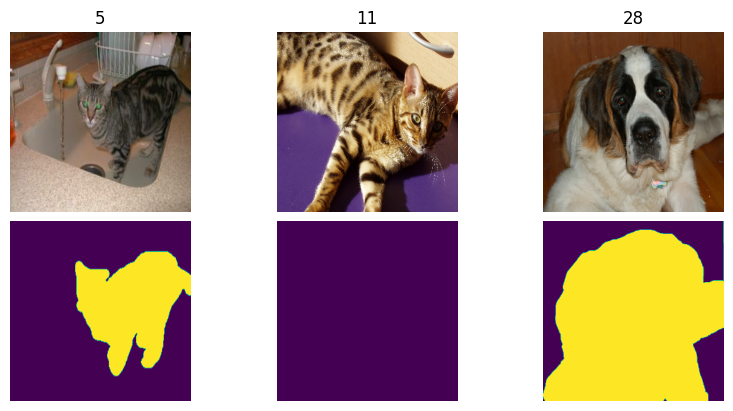

In [5]:
# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
num_plot = 3
i = 0

# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        axs[0, i].set_title(output[0][i])
        axs[0, i].axis('off')
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        axs[1, i].axis('off')
        
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')

The images are showing correctly.

**NOTE: You can ignore the JPEG wearning.**

We can use the ``classification`` and ``segmentation`` flags to pull out just one output as well, as the below demonstrates. 

In [6]:
# classification only; classification = True, segmentation = False (note batch size is 1 here)
train_class_only = load_oxford_pets('train', classification=True, segmentation=False, shuffle=True, augment=True, batch_size=1, image_size=image_size)
# segmentation only; classification = False, segmentation = True (note batch size is 1 here)
train_seg_only = load_oxford_pets('train', classification=False, segmentation=True, shuffle=True, augment=True, batch_size=1, image_size=image_size)

# test the classification only dataset
# pull out one element
inp, out = next(iter(train_class_only))
# print the output
print(out.numpy())

# test the segmentation only dataset
# pull out one element
inp, out = next(iter(train_seg_only))
# print just the output shape for the segmentation output 
print(out.numpy().shape)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


[26]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(1, 300, 300, 1)


While for the question you do need to train networks to do both tasks simultaenously, when you starting playing with the problem it might be easier to get things working for one task, and then add the second.

### Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from keras. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False. This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

More details are available in the keras documentation [here](https://keras.io/api/applications/mobilenet/).

In [7]:
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) ). Depending on what input shape you select you may also be able to eliminate this.

For more information on fine-tuning models, can refer to many of the examples from class, or the [Keras documentation](https://keras.io/guides/transfer_learning/)

## Question 2 Template

The following provides a starting point for your solution, and some suggestions on how to proceed.

In [8]:
#
# Data loading
#
# Use the provided data loader, setting your batch size and image size appropriately.
# Note that you may want to add more augmentation into the data loader.
# For initial experiments you may also want to turn one of classification or segmentation off to allow you to play with a single task.
image_size = 300 # WARNING: THIS VALUE IS STUPID
batch_size = 273 # WARNING: THIS VALUE IS STUPID
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, batch_size=batch_size, image_size=image_size)

# Note that you may also want a non-shuffled version of the training set to help you evaluate training performance. You could simply create another
# training set object with the same settings, but shuffle set to False, i.e.
# train_class_seg_ns = load_oxford_pets('train', classification=True, segmentation=True, shuffle=False, augment=True, batch_size=batch_size, image_size=image_size)

In [9]:
# 
# From-scratch DCNN
#
# Put your from-scratch DCNN here. This network will have one input (the input image), and two outputs (the class, and the segmentation map). You can
# think of your model as having three components:
#  - A backbone, which is going to take your input and encode that. This will possibly be collection of (probably mostly) 2D convolution layers 
#    and max pooling layers (and for which you may be able to find something fairly fit for purpose in lecture or prac examples).
#  - A classification head, which will take the backbone output and via one or more dense layers do the classification task. This will likely only
#    be a few layers at most.
#  - A decoder head, which will do the semantic segmentation. This will look a lot like the back half of an autoencoder.
#
# As usual, the network does not need to be overly complex, but you will need to briefly explain your selection of this model, and you should avoid 
# networks so simple that they perform very badly.
#
# Take note of the order that the outputs appear in the data loader. The data loader will give you (classification_output, segmentation_output), so
# your network should have the outputs in the same order.
#
# When first developing your model, you may want to start by getting a single output of the network going, and then adding the second output. For
# example, you may build a network with the image input and the just the classification head, get that running, and then add the decoder head. You can
# use the classification and segmentation flags in the data loader to turn off one of the outputs.

# For model training, we have provided a callback, TrainForTime, which will terminate training after some time limit is reached. You could use this
# as follows:
#   train_time = 15 # 15-minute training limit
#   my_awesome_model.fit(train_class_seg, epochs=epochs, verbose=True, validation_data=test_class_seg, callbacks=[TrainForTime(train_time)])
# You don't have to use this, but you may wish to use this to ensure training doesn't take too long.
# Note that if you don't train until convergence, you will need to explain what you observe with training and what the implications of this are.

In [10]:
#
# Fine-tuned MobileNet
#
# Pur your mobilenet model here. This will have the same structure as the from-scratch network above, but now the backbone will be mobilenet rather
# than something of your own design. The classification and segmentation heads will possibly be quite similar to what you have above. As per the 
# from-scratch network, you may want to build this with just one output to start with, and then add the second when you get that working.

# load mobilenet backbone
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)
# build the rest of the model here

# train the model. As per the from-scratch model, you may wish to use the callback - though if the model is not trained until convergence you will
# need to explain the implications of this.

In [11]:
#
# Evaluation
#
# You should evaluate both your networks for both tasks. To help generate metrics and plots, you may want to pull out the labels from the dataset
# which you could do with something like the following:
#
# y_class_test = np.concatenate([y[0] for x,y in test_class_seg.as_numpy_iterator()])
# y_seg_test = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])
# 
# For evaluating the two tasks, the classification task is just like all the other classification tasks you've done this semseter and you can follow
# how these have been dealt with. For the segmentation task, one way to look at this is as a binary classification task as you're classifiying each 
# pixel into foreground and background. With that in mind you could do something like this:
#
# class_preds, seg_preds = my_awesome_network.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = y_seg_test.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat)
#
# You could also look at other segmentation specific metrics as a way to evaluate performance

In [12]:
# For your write-up, you should include:
# - A discussion of what pre-processing (i.e. resizing, colour conversion, augmentation, etc.) you apply to the data and why.
# - Details of two implemented methods. This should include a details of the final “from-scratch” approach and justification 
#   for the chosen design, and details of changes made to MobileNetV3Small for the “fine-tuned” approach. Details on how the 
#   models are trained are also to be provided. 
# - An evaluation that compares the two models for the two tasks (classification and semantic segmentation). Your evaluation 
#   should discuss overall model performance, how it differs between the two approaches, and include figures if/where necessary.
# - A discussion of methods that were explored to improve performance for both models and mitigate identified issues, and potentially 
#   other methods that were considered but not implemented due to computational constraints. See the assignment brief for further 
#   details.
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT